In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
drive_path ='/content/BTC_Price.xlsx'

In [ ]:
df = pd.read_excel(drive_path)

df['unix'] = pd.to_numeric(df['unix'])
df['date'] = pd.to_datetime(df['unix'], unit = 's')

In [ ]:
df

,unix,open,high,low,close,volume,trades,date
0,1381093200,122.00000,122.00000,122.00,122.00,0.100000,1,2013-10-06 21:00:00
1,1381176000,123.61000,123.61000,123.61,123.61,0.100000,1,2013-10-07 20:00:00
2,1381197600,123.91000,123.91000,123.90,123.90,1.991600,2,2013-10-08 02:00:00
3,1381208400,124.19000,124.19000,124.18,124.18,2.000000,2,2013-10-08 05:00:00
4,1381309200,124.01687,124.01687,123.84,123.84,2.823000,3,2013-10-09 09:00:00
...,...,...,...,...,...,...,...,...
67886,1664564400,19673.10000,19762.90000,19482.80,19497.20,290.023381,1947,2022-09-30 19:00:00
67887,1664568000,19491.00000,19535.70000,19351.20,19420.40,759.074836,1648,2022-09-30 20:00:00
67888,1664571600,19423.60000,19423.60000,19281.00,19360.40,564.894247,1245,2022-09-30 21:00:00
67889,1664575200,19354.20000,19399.90000,19232.60,19387.10,90.626135,1978,2022-09-30 22:00:00


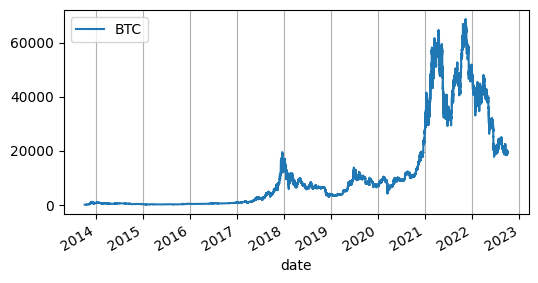

In [ ]:
fig = plt.figure(figsize = (6, 3))
ax = plt.gca()
df.plot(x = 'date', y = 'close', label = 'BTC', ax = ax).grid(axis = 'x')

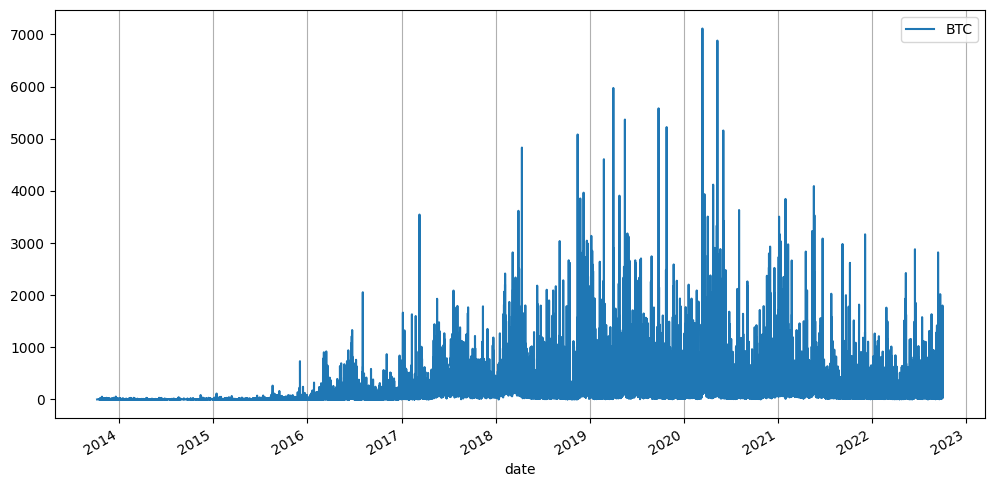

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax = plt.gca()
df.plot(x = 'date', y = 'volume', label = 'BTC', ax = ax).grid(axis = 'x')

<Axes: >

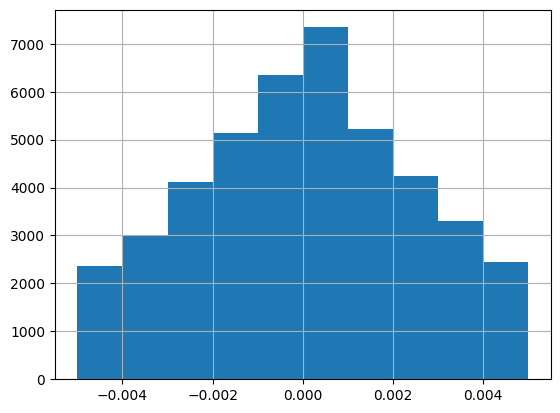

In [ ]:
df['Ret'] = df['close'].pct_change()
df['Ret'].hist(range = [-.005, 0.005])

<Axes: >

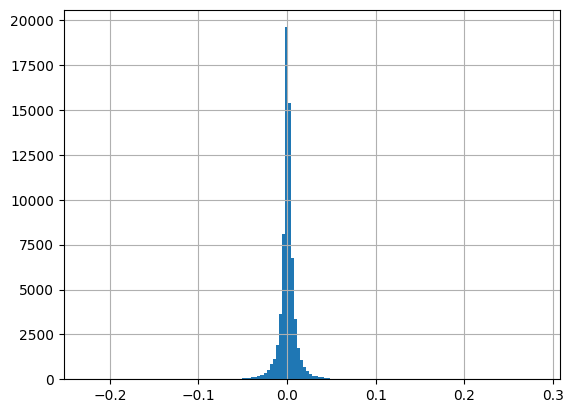

In [ ]:
df['Ret'].hist(bins = 150)

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour

<Axes: xlabel='hour'>

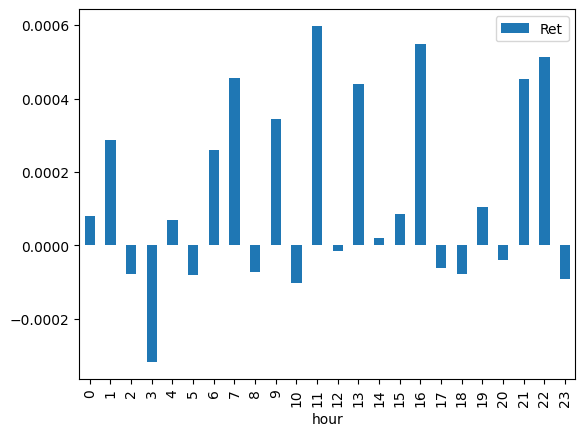

In [ ]:
df_hour = df[['Ret', 'hour']]
df_hour.groupby('hour').mean().plot(kind = 'bar')

<Axes: xlabel='weekday'>

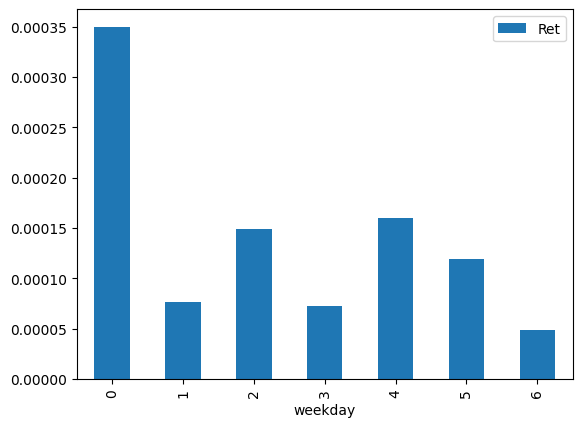

In [ ]:
df_weekday = df[['Ret', 'weekday']]
df_weekday.groupby(by = 'weekday').mean().plot(kind = 'bar')

<Axes: xlabel='month'>

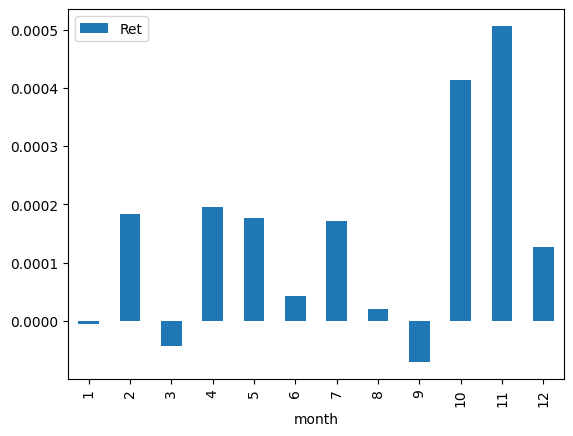

In [ ]:
df_month = df[['Ret', 'month']]
df_month.groupby('month').mean().plot(kind = 'bar')

<Axes: xlabel='date'>

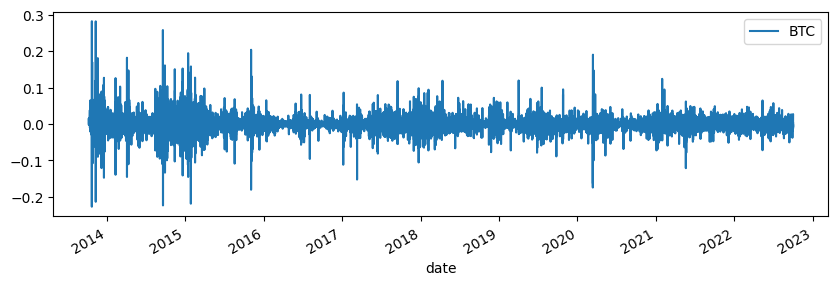

In [ ]:
fig = plt.figure(figsize = (10, 3))
ax = plt.gca()
df.plot(x = 'date', y = 'Ret', label = 'BTC', ax = ax)

### Forecasting

In [ ]:
df.shape

(67891, 15)

In [ ]:
df = df[['date', 'close', 'volume', 'trades']].copy()
df['Ret'] = df['close'].pct_change()
df['year'] = df['date'].dt.year
#del df['close']
df = df.loc[(df['year'] >= 2021)]

In [ ]:
df.shape

(15306, 6)

In [ ]:
df['Ret'] = df['Ret'].fillna(0)
df['volume'] = df['volume'].fillna(0)
df['trades'] = df['trades'].fillna(0)

In [ ]:
df.head(3)

,date,close,volume,trades,Ret,year
52585,2021-01-01 00:00:00,29069.0,272.113148,2071,0.003792,2021
52586,2021-01-01 01:00:00,29452.8,718.037476,3675,0.013203,2021
52587,2021-01-01 02:00:00,29239.9,274.612863,1433,-0.007229,2021


In [ ]:
df = df.reindex(
    columns = [
        'date', 'close', 'Ret', 'volume', 'trades', 'year', 'month', 'day', 'week',
        'weekday', 'hour'
    ]
)
df = df[['date', 'close', 'Ret']]

df['Ret_10'] = df['Ret'].rolling(10).apply(lambda x: np.prod(1 + x) - 1)
df['Ret_50'] = df['Ret'].rolling(50).apply(lambda x: np.prod(1 + x ) - 1)

df['Ret_25'] = df['Ret'].rolling(25).apply(lambda x: np.prod(1 + x) - 1)
df['Ret25'] = df['Ret_25'].shift(-25)
#del df['Ret_25']
#df = df.dropna()


In [ ]:
df.head(10)['Ret'].sum()

0.011102316928986111

In [ ]:
balance  = 1
for i in df['Ret'].head(10):
    balance *= (1 + i)
    print(round(balance, 5))
ret = (balance - 1)
print(round(ret, 5))

1.00379
1.01704
1.00969
1.01322
1.01059
1.00889
1.00861
1.00691
1.00333
1.01099
0.01099


In [ ]:
(101.0994778861294 - 100) / 100

0.010994778861294066

In [ ]:
df.head(26)

,date,close,Ret,Ret_10,Ret_50,Ret_25,Ret25
52585,2021-01-01 00:00:00,29069.0,0.003792,NaN,NaN,NaN,0.000132
52586,2021-01-01 01:00:00,29452.8,0.013203,NaN,NaN,NaN,-0.000007
52587,2021-01-01 02:00:00,29239.9,-0.007229,NaN,NaN,NaN,0.000066
52588,2021-01-01 03:00:00,29342.0,0.003492,NaN,NaN,NaN,0.000034
52589,2021-01-01 04:00:00,29266.0,-0.002590,NaN,NaN,NaN,0.000133
52590,2021-01-01 05:00:00,29216.6,-0.001688,NaN,NaN,NaN,0.000192
52591,2021-01-01 06:00:00,29208.6,-0.000274,NaN,NaN,NaN,0.000211
52592,2021-01-01 07:00:00,29159.4,-0.001684,NaN,NaN,NaN,0.000249
52593,2021-01-01 08:00:00,29055.6,-0.003560,NaN,NaN,NaN,0.000212
52594,2021-01-01 09:00:00,29277.6,0.007641,0.000111,NaN,NaN,0.000162


In [ ]:
Xdf, ydf = df.iloc[:, 1:-1], df.iloc[:, -1]
X = Xdf.astype('float32')
y = ydf.astype('float32')

In [ ]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df) - train_size)

window_size = 30

ts = test_size
split_time = len(df) - ts
test_time = df.iloc[split_time + window_size : , 0:1].values

y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time: ]

n_features = X_train_set.shape[1]

In [ ]:
n_features

3

In [ ]:
scaler_input = MinMaxScaler(feature_range = (-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled  = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret  = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range = (-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1 )

scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [ ]:
training_time = df.iloc[:split_time, 0:1].values


X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print('Shape of training data : ', X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set
for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print('Shape of test data : ', X_test.shape, y_test.shape)

Shape of training data :  (9490, 30, 3) (9490, 1)
Shape of test data :  (5682, 30, 3) (5712, 1)


In [ ]:
X_train.shape[1]

30

In [ ]:
SEED = 1234

units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

from keras import Sequential
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
)
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))


model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=10, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(1))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            10800     
                                                                 
 lstm_5 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)               

In [ ]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
119/119 - 26s - loss: 0.1415 - val_loss: 0.1018 - 26s/epoch - 222ms/step
Epoch 2/100
119/119 - 14s - loss: 0.1363 - val_loss: 0.1004 - 14s/epoch - 116ms/step
Epoch 3/100
119/119 - 14s - loss: 0.1350 - val_loss: 0.1015 - 14s/epoch - 116ms/step
Epoch 4/100
119/119 - 15s - loss: 0.1343 - val_loss: 0.1013 - 15s/epoch - 124ms/step
Epoch 5/100
119/119 - 14s - loss: 0.1336 - val_loss: 0.1010 - 14s/epoch - 115ms/step
Epoch 6/100
119/119 - 14s - loss: 0.1332 - val_loss: 0.1006 - 14s/epoch - 115ms/step
Epoch 7/100
119/119 - 14s - loss: 0.1330 - val_loss: 0.1039 - 14s/epoch - 116ms/step


In [ ]:
prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

#
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()

178/178 [==============================] - 6s 23ms/step
Out-of-sample R-squared: -0.0023950272938637607


,Date,Pred LSTM,values
0,2022-02-05 05:00:00,-0.000021,-0.000017
1,2022-02-05 06:00:00,-0.000021,0.000035
2,2022-02-05 07:00:00,-0.000022,0.000060
3,2022-02-05 08:00:00,-0.000022,0.000046
4,2022-02-05 09:00:00,-0.000022,0.000012


Strat Return = -5.093073844909668 %
Buy and Hold Return = -13.989609479904175 %


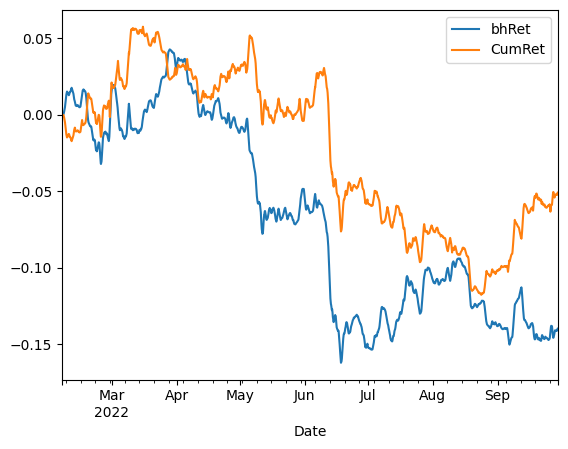

In [ ]:
df_predictions['Positions'] = df_predictions['Pred LSTM'].apply(np.sign)
df_predictions['Strat_ret'] = (
    df_predictions['Positions'].shift(1) * df_predictions['values']
)
df_predictions['CumRet'] = (
    df_predictions['Strat_ret'].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_predictions['bhRet'] = (
    df_predictions['values'].expanding().apply(lambda x: np.prod(1 + x) - 1)
)



Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_predictions["values"]) - 1

print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

ax = plt.gca()
df_predictions.plot(x="Date", y="bhRet", ax=ax)
df_predictions.plot(x="Date", y="CumRet", ax=ax)
plt.show()